**Goal**

The goal is to simulate a ventilator connected to a sedated patient's lung by taking lung attributes compliance and resistance into account.

**Variables**



*   **id** - globally-unique time step identifier across an entire file
*   **breath_id** - globally-unique time step for breaths
*   **R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
*   **C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
*   **time_step** - the actual time stamp.
*   **u_in** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
*   **u_out** - the control input for the exploratory solenoid valve. Either 0 or 1.
*   **pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O



**Evaluation Metric**

The project will be scored as the **mean absolute error** between the predicted and actual pressures during the inspiratory phase of each breath.

**Libraries**

In [2]:
pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261287 sha256=f543e5502a90d57e6d7b1cf74c27f324d155df0bd1369d1849ba360345acd03c
  Stored in directory: /tmp/pip-ephem-wheel-cache-se8x7bnv/wheels/c3/aa/10/94ee985ca5a122f047c430cf991df62fe210c4789d3b5762a5
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=977b35ddbb4ead4ac1a95334f65de8212cbf7986b6da6db55348adf4fee6ca25
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=04efe1ab18bb31645e3f2fc966f7dd72d4bf047c1aa347d9208ee3175bc0622a
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built pandas-profiling htmlmin imagehash
  Attempting uninstall: scipy
    Found existing installati

In [1]:
pip install visualkeras

     |████████████████████████████████| 992 kB 5.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import scipy.stats as stats
from pandas_profiling import ProfileReport
from ipywidgets import widgets
import joblib

from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler,normalize
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings
warnings.filterwarnings("ignore")

In [ ]:
! gdown --id 1TNNsPHd1dVgSx439Ep5BYaIaIAIHCCKy

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TNNsPHd1dVgSx439Ep5BYaIaIAIHCCKy
To: /content/train.csv
100% 440M/440M [00:12<00:00, 34.6MB/s]


In [ ]:
! gdown --id 1H8cQgc82k1c_7X9O2gDLxvQz0N3R0NVE

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1H8cQgc82k1c_7X9O2gDLxvQz0N3R0NVE
To: /content/test.csv
100% 220M/220M [00:07<00:00, 28.5MB/s]


In [ ]:
! gdown --id 1S2KtyTuV-ZChDyWMqlU7J8Z_wByXlGIX

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1S2KtyTuV-ZChDyWMqlU7J8Z_wByXlGIX
To: /content/sample_submission.csv
100% 39.1M/39.1M [00:00<00:00, 59.0MB/s]


In [ ]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')
submission_data = pd.read_csv('/content/sample_submission.csv')

In [3]:
def reduce_mem_usage(data):
  start_mem = data.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  for col in data.columns:
      col_type = data[col].dtype

      if col_type != object:
          c_min = data[col].min()
          c_max = data[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  data[col] = data[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  data[col] = data[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  data[col] = data[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  data[col] = data[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  data[col] = data[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  data[col] = data[col].astype(np.float32)
              else:
                  data[col] = data[col].astype(np.float64)
      else:
          data[col] = data[col].astype('category')

  end_mem = data.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

  return data

In [ ]:
reduce_mem_usage(train_data)

Memory usage of dataframe is 368.41 MB
Memory usage after optimization is: 97.86 MB
Decreased by 73.4%


id  breath_id   R   C  time_step       u_in  u_out   pressure
0              1          1  20  50   0.000000   0.083313      0   5.835938
1              2          1  20  50   0.033661  18.390625      0   5.906250
2              3          1  20  50   0.067505  22.515625      0   7.875000
3              4          1  20  50   0.101562  22.812500      0  11.742188
4              5          1  20  50   0.135742  25.359375      0  12.234375
...          ...        ...  ..  ..        ...        ...    ...        ...
6035995  6035996     125749  50  10   2.503906   1.489258      1   3.869141
6035996  6035997     125749  50  10   2.537109   1.488281      1   3.869141
6035997  6035998     125749  50  10   2.572266   1.558594      1   3.798828
6035998  6035999     125749  50  10   2.605469   1.272461      1   4.078125
6035999  6036000     125749  50  10   2.638672   1.482422      1   3.869141

[6036000 rows x 8 columns]

In [ ]:
reduce_mem_usage(test_data)

Memory usage of dataframe is 214.90 MB
Memory usage after optimization is: 57.56 MB
Decreased by 73.2%


id  breath_id   R   C  time_step       u_in  u_out
0              1          0   5  20   0.000000   0.000000      0
1              2          0   5  20   0.031891   7.515625      0
2              3          0   5  20   0.063843  14.648438      0
3              4          0   5  20   0.095764  21.234375      0
4              5          0   5  20   0.127686  26.328125      0
...          ...        ...  ..  ..        ...        ...    ...
4023995  4023996     125748  20  10   2.529297   4.972656      1
4023996  4023997     125748  20  10   2.564453   4.976562      1
4023997  4023998     125748  20  10   2.597656   4.980469      1
4023998  4023999     125748  20  10   2.630859   4.984375      1
4023999  4024000     125748  20  10   2.666016   4.984375      1

[4024000 rows x 7 columns]

In [ ]:
def data_report(df):
  profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True,plot={"dpi": 200, "image_format": "png"})

  return profile.to_notebook_iframe()

In [ ]:
data_report(train_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data_report(test_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Missing Values**

In [ ]:
train_data.isnull().sum().sum()

0

In [ ]:
test_data.isnull().sum().sum()

0

**Analysis for single breath_id**

In [ ]:
breath_id_1 = train_data[train_data['breath_id']==1]
breath_id_2 = train_data[train_data['breath_id']==2]
breath_id_3 = train_data[train_data['breath_id']==3]

def line_plot(df):
    plt.figure(figsize=(12,6))
    sns.lineplot(df['time_step'],df["pressure"],label="pressure")
    sns.lineplot(df['time_step'],df["u_in"],label="u_in")
    sns.lineplot(df['time_step'],df["u_out"],label="u_out")
  
    plt.show()  

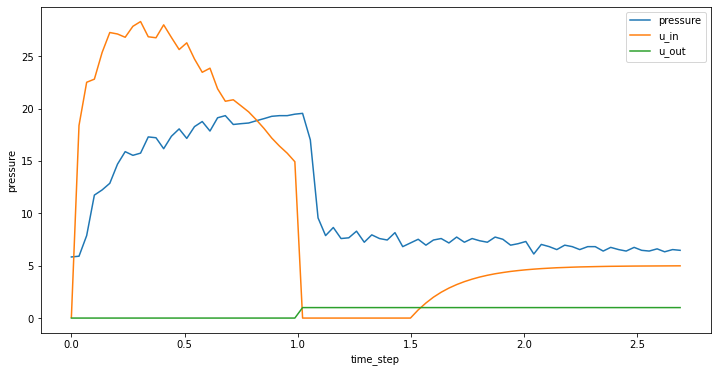

In [ ]:
line_plot(breath_id_1)

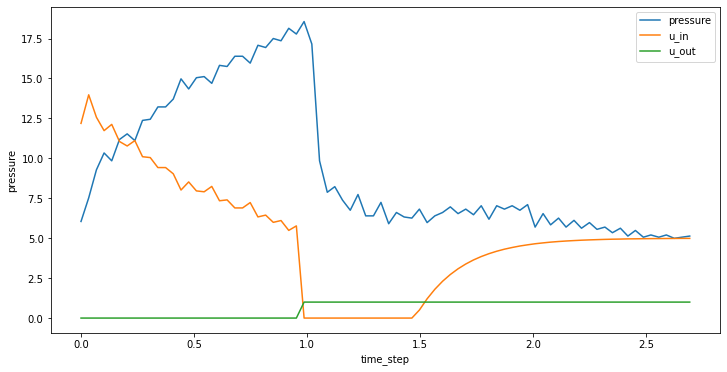

In [ ]:
line_plot(breath_id_2)

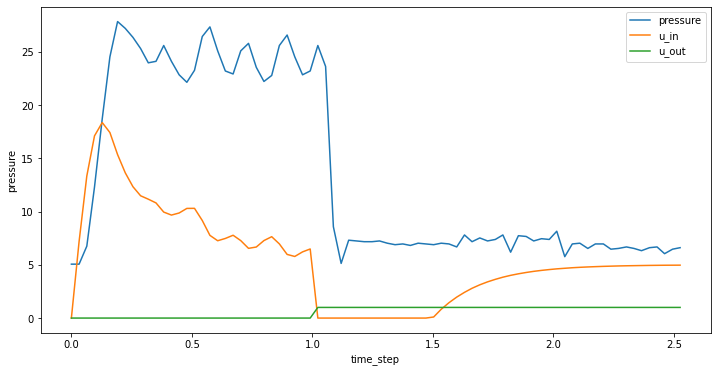

In [ ]:
line_plot(breath_id_3)

**Frequency Distribution of Categorical Features**

In [ ]:
def bar_plot(train,test):
    fig,ax = plt.subplots(figsize=(14,8),nrows=2,ncols=2)
    sns.countplot(x="R",data=train,ax=ax[0,0],palette="muted").set_title("R on Train")
    sns.countplot(x="C",data=train,ax=ax[0,1],palette="colorblind").set_title("C on Train")
    sns.countplot(x="R",data=test,ax=ax[1,0],palette="muted").set_title("R on Test")
    sns.countplot(x="C",data=test,ax=ax[1,1],palette="colorblind").set_title("C on Test")
    plt.show()

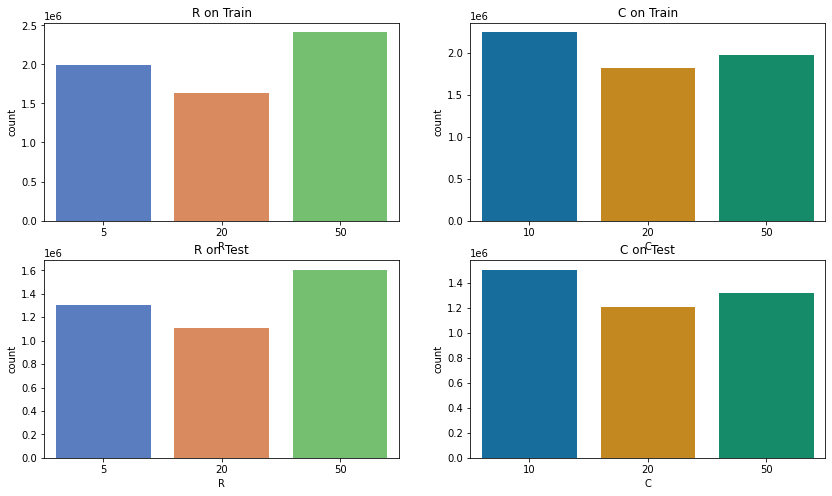

In [ ]:
bar_plot(train_data,test_data)

**Distribution of Features**

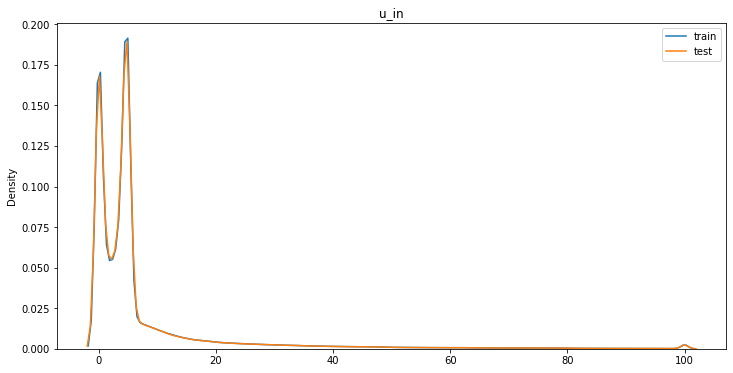

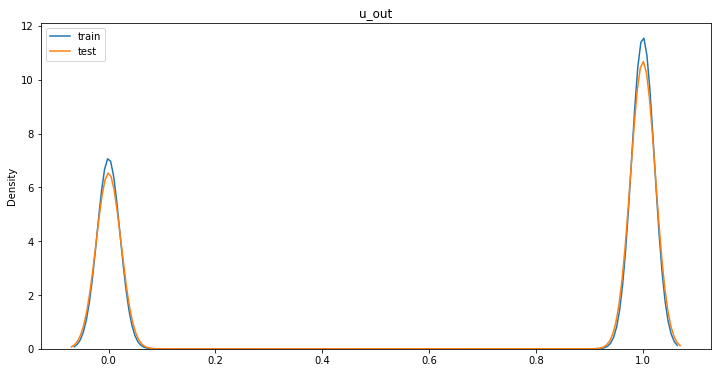

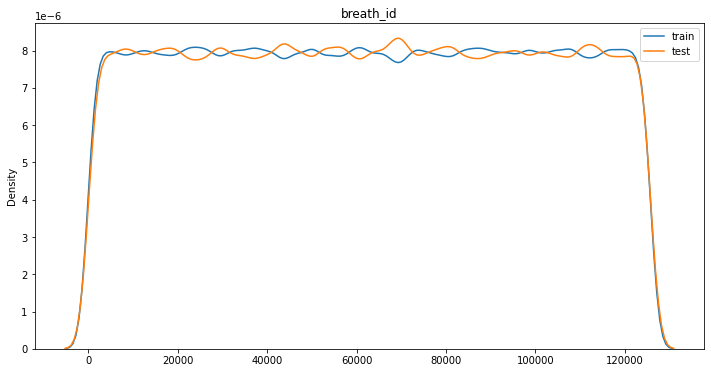

In [ ]:
train_10000 = train_data[:10000]
test_10000 = test_data[:10000]
features = ['u_in','u_out','breath_id']
def kde_plot(train,test,feature):
    train_values = train[feature].to_numpy()
    test_values = test[feature].to_numpy()
    plt.figure(figsize=(12,6))
    sns.kdeplot(train_values,label="train")
    sns.kdeplot(test_values,label="test")
    plt.title(feature)
    plt.legend()
    plt.show()
for col in features:
    kde_plot(train_data,test_data,col)      
    

**Distribution of Target Variable**

((array([-5.1735635 , -5.00539071, -4.91477747, ...,  4.91477747,
          5.00539071,  5.1735635 ]),
  array([-1.8955, -1.8955, -1.8955, ..., 64.8   , 64.8   , 64.8   ],
        dtype=float16)),
 (6.938203617343489, 11.218750000000002, 0.8555639170389833))

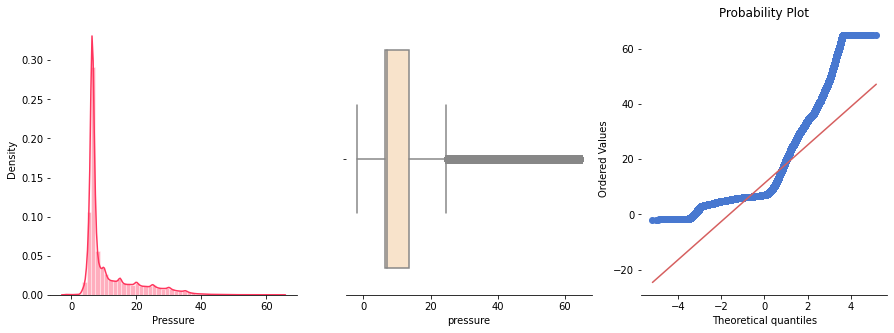

In [ ]:
fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=3)
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)
sns.distplot(x=train_data["pressure"],ax=ax[0],color="#ff355d",kde=True).set_xlabel("Pressure")
sns.boxplot(x=train_data["pressure"],ax=ax[1],color="bisque")
stats.probplot(train_data["pressure"],plot=ax[2])

**Adding Features**

In [4]:
def add_features(df):
  df['area'] = df['time_step'] * df['u_in']
  df['area'] = df.groupby('breath_id')['area'].cumsum()
    
  df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
  df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
  df['R'] = df['R'].astype(str)
  df['C'] = df['C'].astype(str)
  df = pd.get_dummies(df)
  return df

In [ ]:
train_df = add_features(train_data)
test_df = add_features(test_data)
test_df.drop(['id', 'breath_id'], axis=1,inplace=True)

print('Train dataframe shape',train_df.shape)
print('Test dataframe shape',test_df.shape)

Train dataframe shape (6036000, 15)
Test dataframe shape (4024000, 12)


**Defining Features and Target Variable**

In [ ]:
columns = [col for col in train_df.columns if col not in ['id','breath_id','pressure']]
X = train_df[columns]
y = train_df['pressure']

# Modelling

**XGBoost Modelling**



In [ ]:
params = {'learning_rate':0.37,'n_estimators': 800,
'colsample_bytree':0.9,'max_depth':6,'eval_metric':'mae'}

In [ ]:
model =[]
val_scores =[]
train_scores = []

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold_n, (train_index, valid_index) in enumerate(kf.split(X, y)):
  print('Fold:', fold_n)
  X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
  xgb_model = XGBRegressor(**params,n_jobs=-1)
  xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train,y_train),(X_valid,y_valid)],
                  early_stopping_rounds=10, verbose=100)
  y_pred_train = xgb_model.predict(X_train)
  y_pred_val = xgb_model.predict(X_valid)

  mae_train = mean_absolute_error(y_train,y_pred_train)
  mae_val = mean_absolute_error(y_valid, y_pred_val)
   
  model.append(xgb_model)

  train_scores.append(mae_train)
  val_scores.append(mae_val)

  cv_val = np.mean(val_scores)
  std_val = np.std(val_scores)

  cv_train = np.mean(train_scores)
  std_train = np.std(train_scores)

print(f'CV train score: {cv_train}, std: {std_train} ')
print(f'CV val score: {cv_val} , std: {std_val}')
  

Fold: 0
[13:33:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:33:15] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-mae:6.75789	validation_1-mae:6.75979
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[100]	validation_0-mae:0.825544	validation_1-mae:0.828096
[200]	validation_0-mae:0.780949	validation_1-mae:0.784646
[300]	validation_0-mae:0.754037	validation_1-mae:0.75879
[400]	validation_0-mae:0.736787	validation_1-mae:0.742669
[500]	validation_0-mae:0.723406	validation_1-mae:0.730002
[600]	validation_0-mae:0.713178	validation_1-mae:0.720496
[700]	validation_0-mae:0.705181	validation_1-mae:0.71322
[799]	validation_0-mae:0.697607	vali

Save model

In [ ]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

Load model

In [ ]:
xgb_from_joblib = joblib.load('xgb_model.pkl')

In [ ]:
submission_data['pressure'] = xgb_from_joblib.predict(test_df[columns])
submission_data['pressure'] /= 5
submission_data

**LSTM Modelling**

In [5]:
! gdown --id 1TNNsPHd1dVgSx439Ep5BYaIaIAIHCCKy

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TNNsPHd1dVgSx439Ep5BYaIaIAIHCCKy
To: /content/train.csv
100% 440M/440M [00:04<00:00, 105MB/s]


In [6]:
! gdown --id 1H8cQgc82k1c_7X9O2gDLxvQz0N3R0NVE

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1H8cQgc82k1c_7X9O2gDLxvQz0N3R0NVE
To: /content/test.csv
100% 220M/220M [00:01<00:00, 123MB/s]


In [7]:
! gdown --id 1S2KtyTuV-ZChDyWMqlU7J8Z_wByXlGIX

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1S2KtyTuV-ZChDyWMqlU7J8Z_wByXlGIX
To: /content/sample_submission.csv
100% 39.1M/39.1M [00:00<00:00, 92.5MB/s]


In [8]:
train_ff  = pd.read_csv('/content/train.csv')
test_ff  = pd.read_csv('/content/test.csv')
ss_ff  = pd.read_csv('/content/sample_submission.csv')

In [9]:
reduce_mem_usage(train_ff)

Memory usage of dataframe is 368.41 MB
Memory usage after optimization is: 97.86 MB
Decreased by 73.4%


id  breath_id   R   C  time_step       u_in  u_out   pressure
0              1          1  20  50   0.000000   0.083313      0   5.835938
1              2          1  20  50   0.033661  18.390625      0   5.906250
2              3          1  20  50   0.067505  22.515625      0   7.875000
3              4          1  20  50   0.101562  22.812500      0  11.742188
4              5          1  20  50   0.135742  25.359375      0  12.234375
...          ...        ...  ..  ..        ...        ...    ...        ...
6035995  6035996     125749  50  10   2.503906   1.489258      1   3.869141
6035996  6035997     125749  50  10   2.537109   1.488281      1   3.869141
6035997  6035998     125749  50  10   2.572266   1.558594      1   3.798828
6035998  6035999     125749  50  10   2.605469   1.272461      1   4.078125
6035999  6036000     125749  50  10   2.638672   1.482422      1   3.869141

[6036000 rows x 8 columns]

In [10]:
reduce_mem_usage(test_ff)

Memory usage of dataframe is 214.90 MB
Memory usage after optimization is: 57.56 MB
Decreased by 73.2%


id  breath_id   R   C  time_step       u_in  u_out
0              1          0   5  20   0.000000   0.000000      0
1              2          0   5  20   0.031891   7.515625      0
2              3          0   5  20   0.063843  14.648438      0
3              4          0   5  20   0.095764  21.234375      0
4              5          0   5  20   0.127686  26.328125      0
...          ...        ...  ..  ..        ...        ...    ...
4023995  4023996     125748  20  10   2.529297   4.972656      1
4023996  4023997     125748  20  10   2.564453   4.976562      1
4023997  4023998     125748  20  10   2.597656   4.980469      1
4023998  4023999     125748  20  10   2.630859   4.984375      1
4023999  4024000     125748  20  10   2.666016   4.984375      1

[4024000 rows x 7 columns]

In [11]:
train_df_new = add_features(train_ff)
test_df_new = add_features(test_ff)

test_df_new.drop(['id', 'breath_id'], axis=1,inplace=True)
print('Train dataframe shape',train_df_new.shape)
print('Test dataframe shape',test_df_new.shape)


Train dataframe shape (6036000, 15)
Test dataframe shape (4024000, 12)


In [12]:
targets_n = train_df_new[['pressure']].to_numpy().reshape(-1, 80)
train_df_new.drop(['pressure', 'id', 'breath_id'], axis = 1, inplace = True)

In [13]:
RS = RobustScaler()
train_s = RS.fit_transform(train_df_new)
test_s = RS.transform(test_df_new)

In [14]:
train_r = train_s.reshape(-1, 80, train_s.shape[-1])
test_r = test_s.reshape(-1, 80, train_s.shape[-1])

**LSTM Modelling**

In [17]:
EPOCH = 128
BATCH_SIZE = 1024

In [18]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_r, targets_n)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train_r[train_idx], train_r[test_idx]
        y_train, y_valid = targets_n[train_idx], targets_n[test_idx]
        lstm_model = keras.models.Sequential([
            keras.layers.Input(shape = train_r.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences = True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences = True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences = True)),
            keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
            keras.layers.Dense(32, activation = 'selu'),
            keras.layers.Dense(1),
        ])
        lstm_model.compile(optimizer = "adam", loss = "mae")

        scheduler = ExponentialDecay(1e-3, 400*((len(train_r)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose = 1)
        es = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min", restore_best_weights=True)

        history = lstm_model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = EPOCH, batch_size = BATCH_SIZE, callbacks = [es,lr])

        
        test_preds.append(lstm_model.predict(test_r).squeeze().reshape(-1, 1).squeeze())
        plot_history(history)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.49.251.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.251.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


--------------- > Fold 1 < ---------------

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/128
59/59 [==============================] - 60s 621ms/step - loss: 3.4513 - val_loss: 1.9471 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000999511918053031.
Epoch 2/128
59/59 [==============================] - 20s 342ms/step - loss: 1.5430 - val_loss: 1.1726 - lr: 9.9951e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009990239050239325.
Epoch 3/128
59/59 [==============================] - 20s 338ms/step - loss: 1.1330 - val_loss: 1.0764 - lr: 9.9902e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009985362412407994.
Epoch 4/128
59/59 [==============================] - 20s 339ms/step - loss: 0.9121 - val_loss: 0.7859 - lr: 9.9854e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00099804881028831.
Epoch 5/128
59/59 [==============================] - 20s 339ms/step - loss: 0.7822 - val

### Save model

In [ ]:
#saved_lstm_model = lstm_model.save("lstm_model")

In [20]:
model_json = lstm_model.to_json()
with open("lstn_model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Load model

In [ ]:
# load json and create model
json_file = open('lstm_model.json', 'r')
loaded_lstm_model_json = json_file.read()
json_file.close()
loaded_lstm_model = model_from_json(loaded_lstm_model_json)
# load weights into new model
loaded_lstm_model.load_weights("lstm_model.h5")
print("Loaded model from disk")

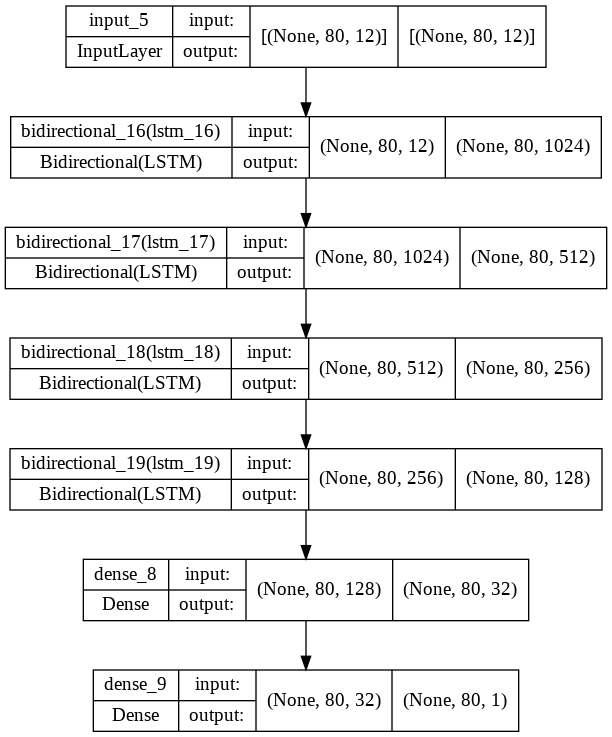

In [27]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(lstm_model, to_file=dot_img_file, show_shapes=True)

In [31]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 80, 1024)         2150400   
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 80, 512)          2623488   
 onal)                                                           
                                                                 
 bidirectional_18 (Bidirecti  (None, 80, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 80, 128)          164352    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 80, 32)           

In [33]:
ss_ff['pressure'] = sum(test_preds) / 5
ss_ff.to_csv('lstm.csv', index = False)

In [34]:
ss_ff.head()

id  pressure
0   1  6.233040
1   2  6.002772
2   3  6.953187
3   4  7.682463
4   5  9.091564